In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression 
import matplotlib.pylab as pylab
import math,time
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout, Activation
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from keras.layers import Bidirectional
test_set_size_percentage = 20 
import pandas as pd
from pandas import read_csv
from sklearn.metrics import r2_score,mean_squared_error 

Using TensorFlow backend.


In [2]:
data=pd.read_csv('dataset/irondata.csv',parse_dates=['date'])

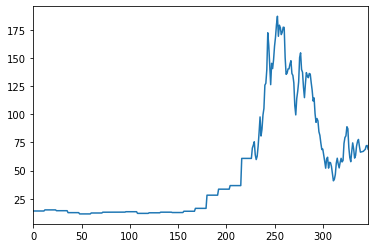

In [3]:
data['price'].plot()
data['price_lag']=data['price'].shift(1)
data=data.set_index('date')
data['rolling_mean_price']=data['price_lag'].rolling(2, min_periods=1).sum()
data=data.dropna()

In [4]:
# function for min-max normalization of Iron Ore 
min_max_scaler = sklearn.preprocessing.MinMaxScaler()
def normalize_data(df):
    df['price'] = min_max_scaler.fit_transform(df.price.values.reshape(-1,1))
    df['price_lag'] = min_max_scaler.fit_transform(df.price_lag.values.reshape(-1,1))
    df['rolling_mean_price'] = min_max_scaler.fit_transform(df.rolling_mean_price.values.reshape(-1,1))
    return df

In [5]:
# normalize stock
df = data.copy()
df = normalize_data(df)
df.head()

,price,price_lag,rolling_mean_price
date,,,
1990-02-28,0.014795,0.014795,0.000000
1990-03-31,0.014795,0.014795,0.039829
1990-04-30,0.014795,0.014795,0.039829
1990-05-31,0.014795,0.014795,0.039829
1990-06-30,0.014795,0.014795,0.039829


In [6]:
train=df[:335]

In [7]:
train.tail()

,price,price_lag,rolling_mean_price
date,,,
2017-08-31,0.359301,0.314630,0.313386
2017-09-30,0.328857,0.359301,0.360812
2017-10-31,0.282251,0.328857,0.367899
2017-11-30,0.295681,0.282251,0.329516
2017-12-31,0.343083,0.295681,0.312989


In [8]:
train_data_raw = train.as_matrix()

C:\Users\sumon\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [9]:
x_train = train_data_raw[:-1,1:] #without price column of train
y_train = train_data_raw[:-1,0] #with price column of train

x_forecast = train_data_raw[-1:,1:]
y_forecast = train_data_raw[-1:,0]

In [10]:
x_forecast

array([[0.29568087, 0.312989  ]])

In [11]:
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_forecast.shape = ', x_forecast.shape)
print('y_forecast.shape ',y_forecast.shape)

x_train.shape =  (334, 2)
y_train.shape =  (334,)
x_forecast.shape =  (1, 2)
y_forecast.shape  (1,)


In [12]:
x_train.shape[0]

334

In [13]:
#Reshape data for (Sample,Timestep,Features) 
x_train = x_train.reshape((x_train.shape[0],1,x_train.shape[1]))
#x_test = x_test.reshape((x_test.shape[0],1,x_test.shape[1]))
#x_forecast = x_forecast.reshape((x_forecast.shape[0],1,x_test.shape[1]))
x_train.shape

(334, 1, 2)

In [14]:
d = 0.3
model = Sequential()

model.add(Bidirectional(LSTM(64, input_shape=(1,2), return_sequences=False))) #timestamp with 2 feature
#model.add(Dropout(d))

#model.add(LSTM(32, input_shape=(1,2), return_sequences=False))
#model.add(Dropout(d))

model.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
model.add(Dense(1,kernel_initializer="uniform",activation='linear'))

# adam = keras.optimizers.Adam(decay=0.2)

start = time.time()
model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
print("Compilation Time : ", time.time() - start)

Compilation Time :  0.02046823501586914


In [15]:
#model.summary()

In [ ]:
#Fit model with history to check for overfitting
history = model.fit(x_train,y_train,batch_size=1,epochs=80,shuffle=False)

Epoch 1/80
334/334 [==============================] - 1s 2ms/step - loss: 0.0022 - accuracy: 0.0389
Epoch 2/80
334/334 [==============================] - 1s 2ms/step - loss: 0.0020 - accuracy: 0.0389
Epoch 3/80
334/334 [==============================] - 1s 2ms/step - loss: 0.0020 - accuracy: 0.0389
Epoch 4/80
334/334 [==============================] - ETA: 0s - loss: 0.0020 - accuracy: 0.04 - 1s 2ms/step - loss: 0.0021 - accuracy: 0.0389
Epoch 5/80
334/334 [==============================] - 1s 2ms/step - loss: 0.0021 - accuracy: 0.0389
Epoch 6/80
334/334 [==============================] - 1s 2ms/step - loss: 0.0021 - accuracy: 0.0389
Epoch 7/80
334/334 [==============================] - 1s 2ms/step - loss: 0.0020 - accuracy: 0.0389
Epoch 8/80
334/334 [==============================] - 1s 2ms/step - loss: 0.0020 - accuracy: 0.0389
Epoch 9/80
334/334 [==============================] - 1s 2ms/step - loss: 0.0020 - accuracy: 0.0389
Epoch 10/80
334/334 [==============================] - 1s 

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("model-weight/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model-weight/model.h5")
print("Saved model to disk")

In [ ]:
# load json and create model
from keras.models import model_from_json
json_file = open('model-weight/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("model-weight/model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])

# forecast till 2018 #

In [ ]:
temp_x_forecast = x_forecast.copy()

In [ ]:
temp_x_forecast

In [ ]:
x_forecast = temp_x_forecast.copy()

In [ ]:
#x_forecast = x_forecast.reshape((x_forecast.shape[0],1,x_forecast.shape[1]))  np.reshape(test_forecast,(1,1,2))
x_forecast = np.reshape(x_forecast,(1,1,2))
x_forecast

In [ ]:
y_forecast[0]

In [ ]:
forecast_val=[]
#t=x_forecast[0][0][0] #take the price lag of last row
t = y_forecast[0] #take the price of last row
t

In [ ]:
forecast_data_index = pd.date_range(start='1/1/2018', periods=12,freq='M')
forecast_data_index

In [ ]:
forecast_data = pd.DataFrame()
forecast_data['date'] = forecast_data_index

In [ ]:
for i in range(1,len(forecast_data)+1):
    m=model.predict(x_forecast)
    print("predict price = ",m.tolist()[0][0])
    print("last price_lag = ", t)
    forecastdf=pd.DataFrame(columns=['price_lag'])
    forecastdf['price_lag']=[t,m.tolist()[0][0]]
    forecastdf['rolling_mean_price']=forecastdf['price_lag'].rolling(2, min_periods=1).sum()
    print(forecastdf)
    x_forecast=forecastdf[:]
    print("matrix",x_forecast)
    x_forecast = x_forecast.as_matrix()
    print("matrix_dd",x_forecast)
    x_forecast = x_forecast.reshape((x_forecast.shape[0],1,x_forecast.shape[1]))
    #x_forecast = np.reshape(x_forecast,(1,1,2))
    t=m.tolist()[0][0]
    forecast_val.append(m.tolist()[0][0])

In [ ]:
forecast_val

In [ ]:
forecast_data['forecast_price'] = forecast_val #normalize value

In [ ]:
#data[:335]

In [ ]:
forecast_data['forecast_price'].plot()

In [ ]:
def denormalize(df, normalized_value): 
    df = df['price'].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)
    #return df.shape, p.shape
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    a = min_max_scaler.fit_transform(df)
    new = min_max_scaler.inverse_transform(normalized_value)
    return new

# newp = denormalize(data, pred_price)
# newy_test = denormalize(data, y_test)

In [ ]:
new_forecast = denormalize(data[:335], np.array(forecast_val))
forecast_data['forecast_price'] = new_forecast #denorm_price
forecast_data = forecast_data.set_index('date')
forecast_data.forecast_price.plot()

In [ ]:
forecast_data

In [ ]:
data[335:]['price'] #actual price

In [ ]:
def forecast_accuracy(forecast, actual):
    mape=np.mean(np.abs(forecast-actual)/np.abs(actual))# MAPE
    me=np.mean(forecast-actual)# ME
    mae=np.mean(np.abs(forecast-actual))# MAE
    mpe=np.mean((forecast-actual)/actual)# MPE
    return({'mape':mape,'me':me,'mae': mae,'mpe': mpe})
print(forecast_accuracy(forecast_data.forecast_price.values, data[335:]['price'].values))
forecast_data['actual']=data[335:]['price'].values
forecast_data

In [ ]:
forecast_data.plot(figsize=(15,5))